In [1]:
import os
import sys

# Get the absolute path to the parent folder
parent_folder = os.path.abspath(os.path.join(os.getcwd(), "..", os.pardir))

# Add the parent folder to sys.path if it's not already included
if parent_folder not in sys.path:
    sys.path.append(parent_folder)

import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from agents.sarsa import Sarsa
from agents.qlearning import QLearning
from policies.eps_greedy_policy import EpsGreedy
from policies.softmax_policy import Softmax

from utils.encoding import cw_encoding
from utils.utils_fct import line_bar_plot, plot_moving_averages, process_json

env = gym.make("CliffWalking-v0", is_slippery=True, render_mode=None)

In [68]:
import gymnasium as gym
import numpy as np
from gymnasium.envs.toy_text import CliffWalkingEnv


class CustomCliffWalkingEnv(CliffWalkingEnv):
    def __init__(self, render_mode, stochastic_prob=0.33):
        super().__init__()
        self.render_mode = render_mode
        self.stochastic_prob = stochastic_prob  # Default probability for random actions

    def step(self, action):
        # Use the `stochastic_prob` to determine randomness
        if np.random.rand() < self.stochastic_prob:
            action = self.np_random.choice(self.action_space.n)

        # Call the parent step method
        state, reward, done, truncated, info = super().step(action)

        # Update the `info` dictionary with the current `prob`
        info["prob"] = self.stochastic_prob

        return state, reward, done, truncated, info


# Instantiate and use the custom environment
env = CustomCliffWalkingEnv(render_mode="human", stochastic_prob=0.7)
state = env.reset()
env.step(1)

(36, -100, False, False, {'prob': 0.7})

In [91]:
env.step(0)

(12, -1, False, False, {'prob': 0.7})

In [93]:
env = gym.make("CliffWalking-v0", is_slippery=True, render_mode=None)

In [7]:
env.reset()

(36, {'prob': 1})

In [9]:
env.step(0)

(36, -100, False, False, {'prob': 0.3333333333333333})

# I. Sarsa vs QLearning (Stochastic start)

## I.1. $\epsilon$-Greedy agents

In [4]:
eps_greedy_sarsa = Sarsa(
    encode_fct=cw_encoding,
    policy=EpsGreedy(0.001),
    nb_actions=env.action_space.n,
)

eps_greedy_qlearning = QLearning(
    encode_fct=cw_encoding,
    policy=EpsGreedy(0.05),
    nb_actions=env.action_space.n,
)

### 1.1. Evaluating agents

In [5]:
sarsa_training_data = []
sarsa_evaluation_data = {"x": [], "data": []}


for i in range(10):
    eps_greedy_sarsa_rewards, eps_greedy_sarsa_evaluations = eps_greedy_sarsa.train(
        env=env,
        policy_action_params={},
        policy_update_params={"use_glei": True},
        alpha=0.1,
        gamma=0.9,
        nb_episodes=500,
        to_evaluate=True,
        evaluation_frequency=5,
        verbose=0,
    )
    sarsa_training_data.append(eps_greedy_sarsa_rewards)
    sarsa_evaluation_data["data"].append(eps_greedy_sarsa_evaluations["data"])

sarsa_training_data = np.mean(np.array(sarsa_training_data), axis=0)

sarsa_evaluation_data["x"] = eps_greedy_sarsa_evaluations["x"]
sarsa_evaluation_data["data"] = np.mean(np.array(sarsa_evaluation_data["data"]), axis=0)


qlearning_training_data = []
qlearning_evaluation_data = {"x": [], "data": []}

for i in range(10):
    eps_greedy_qlearning_rewards, eps_greedy_qlearning_evaluations = (
        eps_greedy_qlearning.train(
            env=env,
            policy_action_params={},
            policy_update_params={"use_glei": True},
            alpha=0.1,
            gamma=0.9,
            nb_episodes=500,
            to_evaluate=True,
            evaluation_frequency=5,
            verbose=0,
        )
    )
    qlearning_training_data.append(eps_greedy_qlearning_rewards)
    qlearning_evaluation_data["data"].append(eps_greedy_qlearning_evaluations["data"])

qlearning_training_data = np.mean(np.array(qlearning_training_data), axis=0)

qlearning_evaluation_data["x"] = eps_greedy_qlearning_evaluations["x"]
qlearning_evaluation_data["data"] = np.mean(
    np.array(qlearning_evaluation_data["data"]), axis=0
)

In [6]:
sarsa_training_data = list(sarsa_training_data)
qlearning_training_data = list(qlearning_training_data)
sarsa_evaluation_data["data"] = list(sarsa_evaluation_data["data"])
qlearning_evaluation_data["data"] = list(qlearning_evaluation_data["data"])

process_json(
    "../../data/cliff_walking/compare/eps_greedy/sarsa_vs_qlearning_500ep",
    "w",
    data_dict={
        "training_data": {
            "sarsa training": sarsa_training_data,
            "qlearning training": qlearning_training_data,
        },
        "evaluation_data": {
            "sarsa evaluation": sarsa_evaluation_data,
            "qlearning evaluation": qlearning_evaluation_data,
        },
    },
)

Dictionary saved to ../../data/cliff_walking/compare/eps_greedy/sarsa_vs_qlearning_500ep


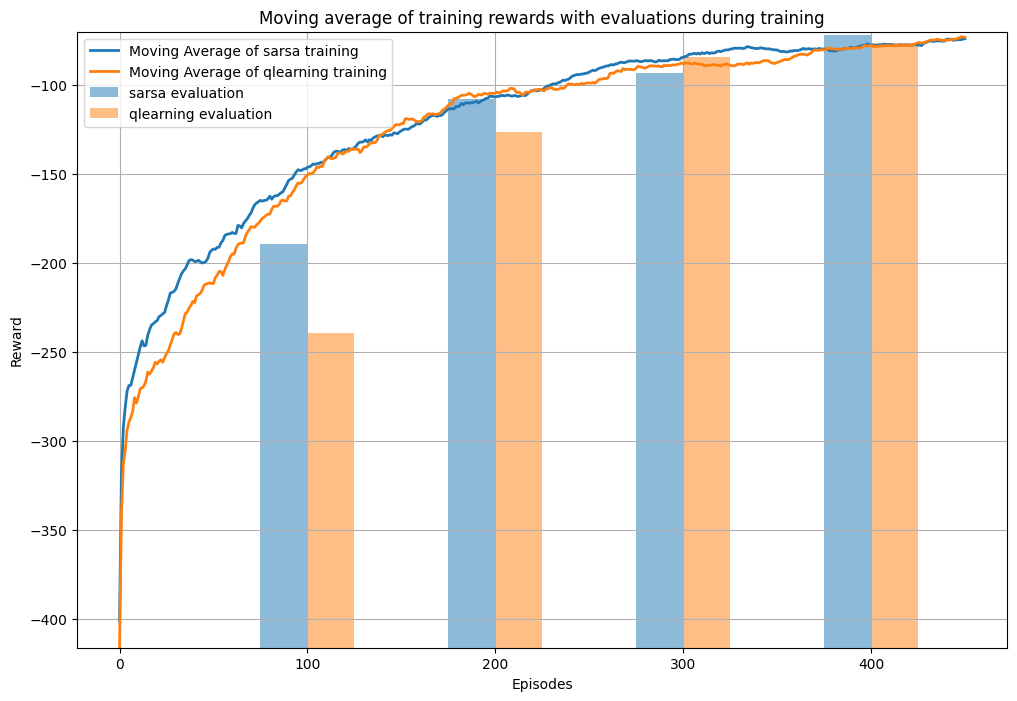

In [5]:
data_dict = process_json(
    "../../data/cliff_walking/compare/eps_greedy/sarsa_vs_qlearning_500ep", "r"
)
line_bar_plot(
    lineplot_window_size=50,
    bar_chart_width=50,
    traning_data=data_dict["training_data"],
    evaluation_data=data_dict["evaluation_data"],
)

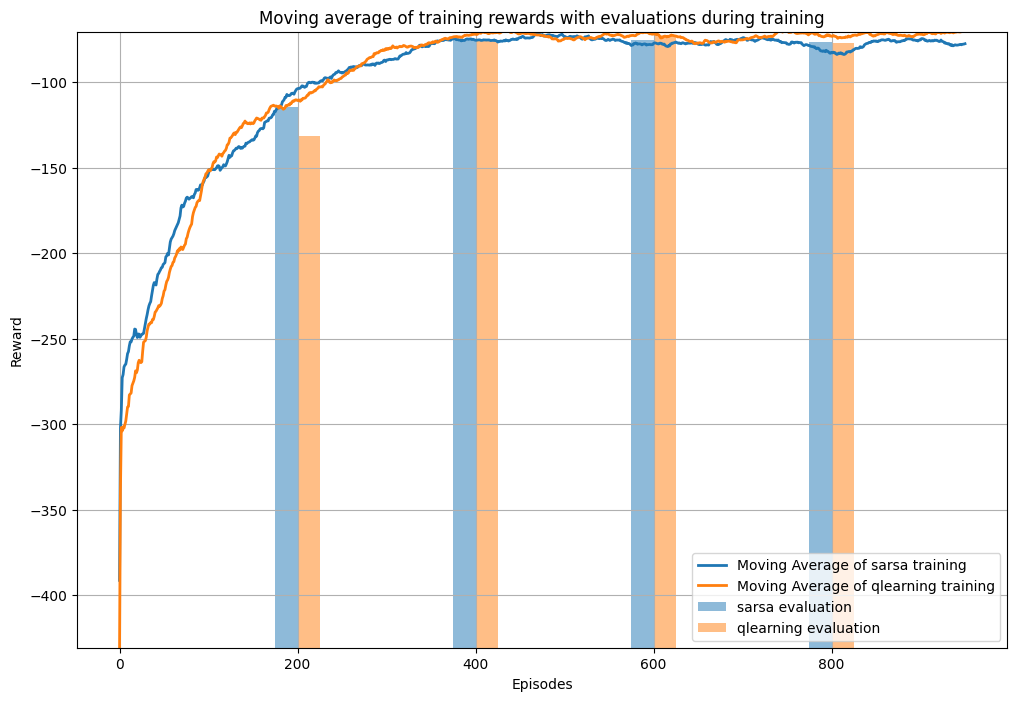

In [4]:
data_dict = process_json(
    "../../data/cliff_walking/compare/eps_greedy/sarsa_vs_qlearning", "r"
)
line_bar_plot(
    lineplot_window_size=50,
    bar_chart_width=50,
    traning_data=data_dict["training_data"],
    evaluation_data=data_dict["evaluation_data"],
)

## I.2. Softmax agents

### 2.1. Evaluating agents

In [6]:
softmax_sarsa = Sarsa(
    encode_fct=cw_encoding,
    policy=Softmax(1),
    nb_actions=env.action_space.n,
)

softmax_qlearning = QLearning(
    encode_fct=cw_encoding,
    policy=Softmax(1),
    nb_actions=env.action_space.n,
)

In [37]:
softmax_sarsa_training_data = []
softmax_sarsa_evaluation_data = {"x": [], "data": []}


for i in range(10):
    softmax_sarsa_rewards, softmax_sarsa_evaluations = softmax_sarsa.train(
        env=env,
        policy_action_params={},
        policy_update_params={},
        alpha=0.4,
        gamma=1,
        nb_episodes=500,
        to_evaluate=True,
        evaluation_frequency=5,
        verbose=0,
    )
    softmax_sarsa_training_data.append(softmax_sarsa_rewards)
    softmax_sarsa_evaluation_data["data"].append(softmax_sarsa_evaluations["data"])

softmax_sarsa_training_data = np.mean(np.array(softmax_sarsa_training_data), axis=0)

softmax_sarsa_evaluation_data["x"] = softmax_sarsa_evaluations["x"]
softmax_sarsa_evaluation_data["data"] = np.mean(
    np.array(softmax_sarsa_evaluation_data["data"]), axis=0
)


softmax_qlearning_training_data = []
softmax_qlearning_evaluation_data = {"x": [], "data": []}
for i in range(10):
    softmax_qlearning_rewards, softmax_qlearning_evaluations = softmax_qlearning.train(
        env=env,
        policy_action_params={},
        policy_update_params={},
        alpha=0.4,
        gamma=1,
        nb_episodes=500,
        to_evaluate=True,
        evaluation_frequency=5,
        verbose=0,
    )
    softmax_qlearning_training_data.append(softmax_qlearning_rewards)
    softmax_qlearning_evaluation_data["data"].append(
        softmax_qlearning_evaluations["data"]
    )

softmax_qlearning_training_data = np.mean(
    np.array(softmax_qlearning_training_data), axis=0
)

softmax_qlearning_evaluation_data["x"] = softmax_qlearning_evaluations["x"]
softmax_qlearning_evaluation_data["data"] = np.mean(
    np.array(softmax_qlearning_evaluation_data["data"]), axis=0
)

In [38]:
softmax_sarsa_training_data = list(softmax_sarsa_training_data)
softmax_qlearning_training_data = list(softmax_qlearning_training_data)
softmax_sarsa_evaluation_data["data"] = list(softmax_sarsa_evaluation_data["data"])
softmax_qlearning_evaluation_data["data"] = list(
    softmax_qlearning_evaluation_data["data"]
)

process_json(
    "../../data/cliff_walking/compare/softmax/sarsa_vs_qlearning_500ep_v2",
    "w",
    data_dict={
        "training_data": {
            "sarsa training": softmax_sarsa_training_data,
            "qlearning training": softmax_qlearning_training_data,
        },
        "evaluation_data": {
            "sarsa evaluation": softmax_sarsa_evaluation_data,
            "qlearning evaluations": softmax_qlearning_evaluation_data,
        },
    },
)

Dictionary saved to ../../data/cliff_walking/compare/softmax/sarsa_vs_qlearning_500ep_v2


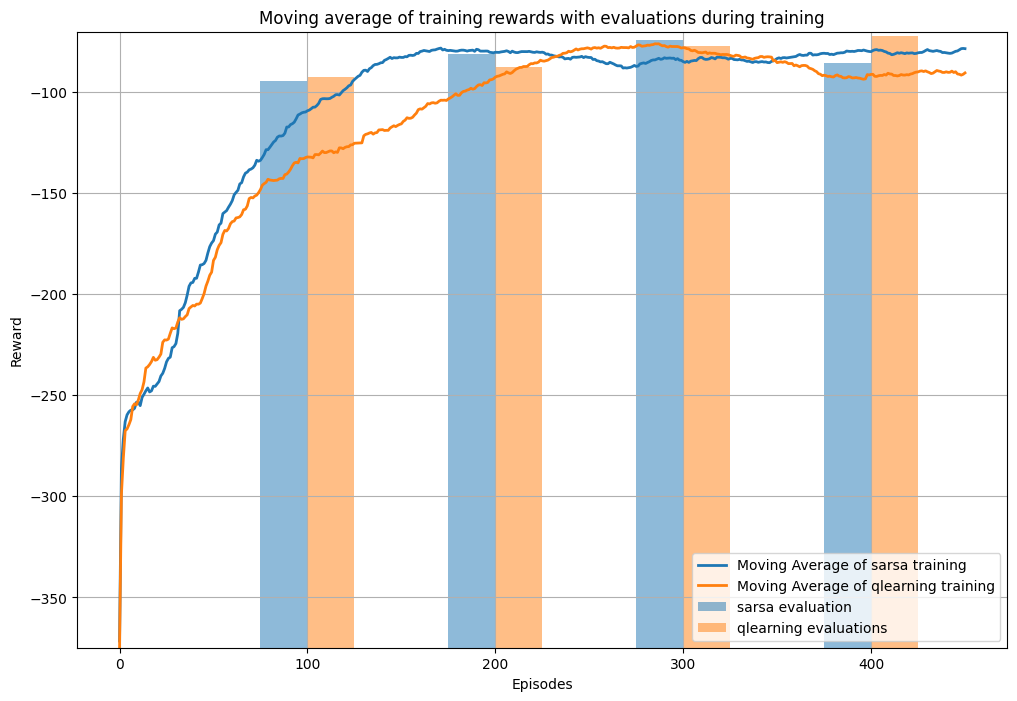

In [2]:
data_dict = process_json(
    "../../data/cliff_walking/compare/softmax/sarsa_vs_qlearning_500ep_v2", "r"
)
line_bar_plot(
    lineplot_window_size=50,
    bar_chart_width=50,
    traning_data=data_dict["training_data"],
    evaluation_data=data_dict["evaluation_data"],
)